# Deep Learning Project – Sports Image Classification

## **PHASE 1**

## **1. All the Libraries Needed**


In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import os, datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import threading
import time
from tensorboard import notebook
import torch.nn.utils as nn_utils
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau

## **2. Load and Explore the Data**

In [3]:
train_df = pd.read_csv('/kaggle/input/sport-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/sport-classification/test.csv')

In [4]:
print(train_df.head())


         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket


In [5]:
train_df['label'].value_counts()

label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Labels in Training Set')

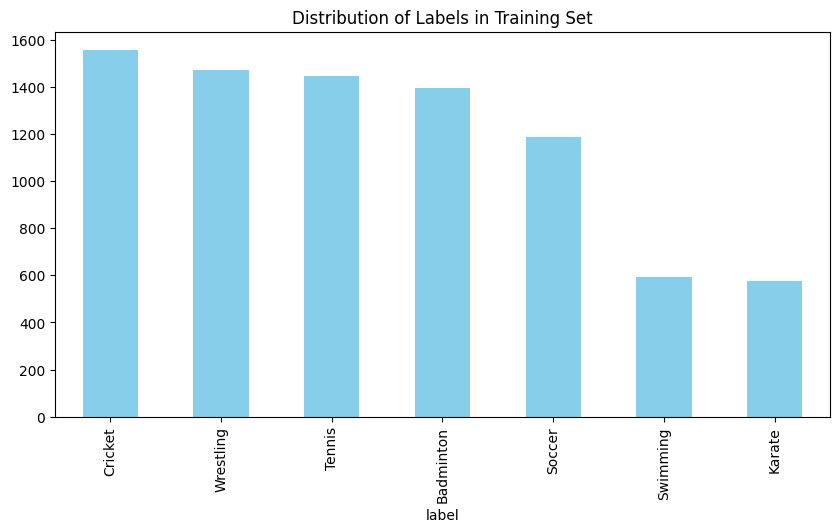

In [6]:
train_df['label'].value_counts().plot(kind='bar', figsize=(10, 5), color='skyblue')
plt.title('Distribution of Labels in Training Set')

In [7]:
train_df.tail()

,image_ID,label
8222,903d2fffb3.jpg,Cricket
8223,b5f174c688.jpg,Badminton
8224,2433770a67.jpg,Tennis
8225,6403964166.jpg,Tennis
8226,f07f00564e.jpg,Swimming


In [8]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8227 entries, 0 to 8226
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_ID  8227 non-null   object
 1   label     8227 non-null   object
dtypes: object(2)
memory usage: 128.7+ KB


,image_ID,label
count,8227,8227
unique,8227,7
top,f07f00564e.jpg,Cricket
freq,1,1556


## **3. Clean the Data**

In [9]:
print(train_df.isnull().sum())
train_df.drop_duplicates(inplace=True)

image_ID    0
label       0
dtype: int64


## **4. Visualize the Class Distribution**

Text(0.5, 1.0, 'Distribution of Sports Classes')

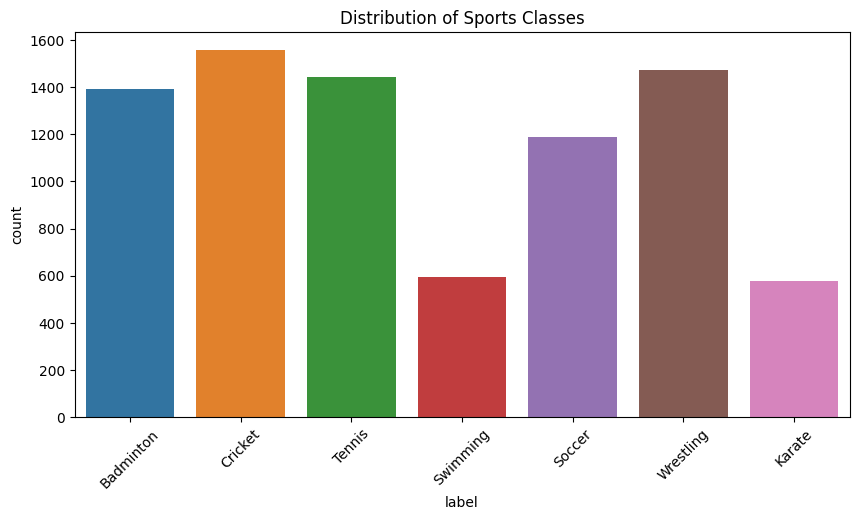

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(data=train_df, x='label')
plt.xticks(rotation=45)
plt.title("Distribution of Sports Classes")

## **5. Encode the Labels**

In [11]:
le = LabelEncoder()
train_df['encoded_label'] = le.fit_transform(train_df['label'])
classes = le.classes_

In [24]:
labels = train_df['encoded_label']
print("Min label:", labels.min())
print("Max label:", labels.max())
print("Unique labels:", sorted(labels.unique()))
print("Expected range:", list(range(labels.nunique())))


Min label: 0
Max label: 6
Unique labels: [0, 1, 2, 3, 4, 5, 6]
Expected range: [0, 1, 2, 3, 4, 5, 6]


## **6. Preprocess the Images for Training**

In [67]:
# For training (strong augmentations)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])



In [55]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [18]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


## **PHASE 2**

## **Setup TensorBoard Logging**

In [13]:
logdir = os.path.join("runs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
writer = SummaryWriter(log_dir='runs/my_experiment')
print(f"Logging to {logdir}")

Logging to runs/20250504-142553


## **Training and Evaluation Functions**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [25]:
class SportsDataset(Dataset):
    def __init__(self, dataframe=None, img_dir="", transform=None, test_mode=False):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform or transforms.ToTensor()
        self.test_mode = test_mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_ID']
        img_path = os.path.join(self.img_dir, img_name)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        if self.test_mode:
            return image, img_name
        else:
            label = torch.tensor(row['encoded_label'], dtype=torch.long)
            return image, label


In [56]:
train_dataset = SportsDataset(train_df, "/kaggle/input/sports-image-classification/dataset/train", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

test_dataset = SportsDataset(test_df, "/kaggle/input/sports-image-classification/dataset/test", transform=test_transform, test_mode=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


In [27]:
def train_model(model, train_loader, criterion, optimizer, device, writer, tag,
                scheduler=None, epochs=5, checkpoint_path=None, grad_clip=None):

    model.to(device)
    start_epoch = 0

    # Resume from checkpoint if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"🧩 Resuming from checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and 'scheduler_state_dict' in checkpoint:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"👉 Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\n🔄 Epoch {epoch + 1}/{epochs}")
        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}")

        for i, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            if grad_clip:
                nn_utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 10 == 0:
                acc = 100 * correct / total
                loop.set_postfix(loss=loss.item(), acc=acc)

        acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        writer.add_scalar(f'{tag}/Loss', avg_loss, epoch)
        writer.add_scalar(f'{tag}/Accuracy', acc, epoch)
        print(f"[{tag}] ✅ Epoch {epoch+1} Complete — Avg Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

        if scheduler:
            scheduler.step()

        if checkpoint_path:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'loss': avg_loss
            }, checkpoint_path)
            print(f"💾 Checkpoint saved at: {checkpoint_path}")

In [28]:
def evaluate_model_on_train(model, train_loader, criterion, device, writer=None, tag="Eval", epoch=0):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    print("🔍 Starting evaluation on training set...")
    with torch.no_grad():
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)  # weight by batch size
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if i % 10 == 0:
                batch_acc = 100.0 * (predicted == labels).sum().item() / labels.size(0)
                print(f"  🔁 Batch {i}: Loss = {loss.item():.4f}, Batch Accuracy = {batch_acc:.2f}%")

    accuracy = 100.0 * correct / total
    avg_loss = total_loss / total  # weighted average across dataset

    print(f"✅ Evaluation Complete — Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}")

    if writer:
        writer.add_scalar(f'{tag}/Accuracy', accuracy, epoch)
        writer.add_scalar(f'{tag}/Loss', avg_loss, epoch)

    return accuracy, avg_loss


## **setup**

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
num_classes = len(train_df['encoded_label'].unique())


## **Analyze Weight Decay (L2 Regularization)**

Constant hyperparameters:
Model architecture (resnet18)

Dropout rate: 0.3

Learning rate: 0.001

Optimizer: Adam

No learning rate scheduler here

In [ ]:
decay_values = [0.0, 1e-4, 1e-3]
decay_results = []

for wd in decay_values:
    tag = f"L2_{wd}"
    
    # Kaggle: working directory to store checkpoints
    checkpoint_path = f"/kaggle/working/checkpoint_L2_{wd}.pth"
    
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(model.fc.in_features, num_classes))
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)

    # Resume if checkpoint exists (within this session)
    if os.path.exists(checkpoint_path):
        print(f"🔁 Resuming training from: {checkpoint_path}")
    else:
        print(f"🚀 Starting fresh training for weight decay: {wd}")

    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    # Save model to working directory
    model_path = f"/kaggle/working/best_model_L2_{wd}.pth"
    torch.save(model.state_dict(), model_path)

    # Evaluate
    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    decay_results.append((wd, acc, loss))
    print(f"{tag} → Train Accuracy: {acc:.2f}%, Loss: {loss:.4f}")


## **Learning Rate Scheduler (StepLR)**

Learning rate (lr=0.001) is fixed

Weight decay (1e-4) is fixed

Dropout is fixed

Model structure is fixed

Optimizer (Adam) is fixed

Scheduler (StepLR) is the new variable introduced

In [ ]:
# === Hyperparameter search setup ===
learning_rates = [0.01, 0.001, 0.0005]
schedulers = {
    "StepLR": lambda opt: StepLR(opt, step_size=2, gamma=0.5),
    "CosineAnnealingLR": lambda opt: CosineAnnealingLR(opt, T_max=5),
    "ReduceLROnPlateau": lambda opt: ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=1)
}

scheduler_results = []

# === Loop over learning rates and schedulers ===
for lr in learning_rates:
    for sched_name, sched_func in schedulers.items():
        tag = f"{sched_name}_LR{lr}"
        print(f"\n🔁 Training with LR={lr}, Scheduler={sched_name}")
        
        # Model setup
        model = models.resnet18(pretrained=True)
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(model.fc.in_features, num_classes)
        )

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = sched_func(optimizer)
        
        # Checkpoint path
        checkpoint_path = f"/kaggle/working/checkpoint_{tag}.pth"
        
        # Train
        train_model(
            model=model,
            train_loader=train_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            writer=writer,
            tag=tag,
            scheduler=scheduler if sched_name != "ReduceLROnPlateau" else None,  # handled in training manually
            epochs=5,
            checkpoint_path=checkpoint_path
        )

        # Save final model
        torch.save(model.state_dict(), f"/kaggle/working/best_model_{tag}.pth")
        
        # Evaluate
        acc, loss = evaluate_model_on_train(
            model=model,
            train_loader=train_loader,
            criterion=criterion,
            device=device,
            writer=writer,
            tag=f"{tag}_Eval",
            epoch=4
        )
        
        scheduler_results.append((tag, acc, loss))
        print(f"✅ {tag}: Accuracy = {acc:.2f}%, Loss = {loss:.4f}")

## **Plot Weight Decay Results**

In [ ]:
decay_values = [x[0] for x in decay_results]
accuracies = [x[1] for x in decay_results]

plt.figure(figsize=(8,5))
plt.plot(decay_values, accuracies, marker='o')
plt.title("Effect of Weight Decay on Test Accuracy")
plt.xlabel("Weight Decay")
plt.ylabel("Accuracy (%)")
plt.xscale('log')
plt.grid(True)
plt.show()


## **Optimizers**

In [ ]:
optimizers = {
    "Adam": torch.optim.Adam,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop
}

optimizer_results = []

for opt_name, opt_class in optimizers.items():
    print(f"🔄 Training with optimizer: {opt_name}")

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )

    optimizer = opt_class(model.parameters(), lr=0.001, weight_decay=1e-4)

    tag = f"Optimizer_{opt_name}"
    checkpoint_path = f"/kaggle/working/checkpoint_optimizer_{opt_name}.pth"

    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path  
    )

    model_path = f"/kaggle/working/best_model_optimizer_{opt_name}.pth"
    torch.save(model.state_dict(), model_path)

    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    optimizer_results.append((opt_name, acc, loss))
    print(f"✅ {opt_name} Accuracy: {acc:.2f}% , Loss: {loss:.4f}")


## **DROPOUT Rates**

In [ ]:
dropout_rates = [0.0, 0.3, 0.5]
dropout_results = []

for rate in dropout_rates:
    print(f"🔄 Training with dropout rate: {rate}")

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(rate),  # 🔁 only this changes
        nn.Linear(model.fc.in_features, num_classes)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    tag = f"Dropout_{rate}"
    
    checkpoint_path = f"/kaggle/working/checkpoint_dropout_{rate}.pth"
    model_path = f"/kaggle/working/best_model_dropout_{rate}.pth"
    
    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    torch.save(model.state_dict(), model_path)

    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    dropout_results.append((rate, acc, loss))
    print(f"✅ Dropout {rate} Accuracy: {acc:.2f}% , Loss: {loss:.4f}")


In [ ]:
rates = [x[0] for x in dropout_results]
accs = [x[1] for x in dropout_results]

plt.figure(figsize=(8,5))
plt.plot(rates, accs, marker='o')
plt.title("Effect of Dropout Rate on Test Accuracy")
plt.xlabel("Dropout Rate")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()


## **Batch Size**

In [ ]:
batch_sizes = [16, 32, 64]
batch_results = []

for bs in batch_sizes:
    print(f"\n🔄 Training with batch size: {bs}")

    # Create DataLoaders for this batch size
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.fc.in_features, num_classes)
    )
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    tag = f"BatchSize_{bs}"

    checkpoint_path = f"/kaggle/working/checkpoint_batch_{bs}.pth"
    model_path = f"/kaggle/working/best_model_batch_{bs}.pth"

    # Train
    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    # Save model weights
    torch.save(model.state_dict(), model_path)

    # Evaluate
    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    batch_results.append((bs, acc, loss))
    print(f"✅ Batch Size {bs} Accuracy: {acc:.2f}%, Loss: {loss:.4f}")


## **Number of Layers**

In [37]:
layer_configs = {
    "1-layer": lambda in_features: nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, num_classes)
    ),
    "2-layer": lambda in_features: nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    ),
    "3-layer": lambda in_features: nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
}

layer_results = []

for name, classifier_factory in layer_configs.items():
    print(f"\n🔄 Training with {name}")

    model = models.resnet18(pretrained=True)
    in_features = model.fc.in_features
    model.fc = classifier_factory(in_features)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    tag = f"NumLayers_{name.replace('-', '')}"

    checkpoint_path = f"/kaggle/working/checkpoint_layers_{name.replace('-', '')}.pth"
    model_path = f"/kaggle/working/best_model_layers_{name.replace('-', '')}.pth"

    train_model(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        writer=writer,
        tag=tag,
        scheduler=None,
        epochs=5,
        checkpoint_path=checkpoint_path
    )

    torch.save(model.state_dict(), model_path)

    acc, loss = evaluate_model_on_train(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        device=device,
        writer=writer,
        tag=f"{tag}_Eval",
        epoch=4
    )

    layer_results.append((name, acc, loss))
    print(f"✅ {name} Accuracy: {acc:.2f}%, Loss: {loss:.4f}")



🔄 Training with 1-layer


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]



🔄 Epoch 1/5


Epoch 1:  34%|███▎      | 87/258 [00:46<01:30,  1.89it/s, acc=58.2, loss=0.904]


KeyboardInterrupt: 

## *for plotting instead of Tenserboard*

In [31]:
def plot_results(results, xlabel, title, csv_filename=None):
    # Convert to DataFrame
    df = pd.DataFrame(results, columns=[xlabel, 'Accuracy', 'Loss'])

    # Sort by x-axis (e.g., dropout rate or batch size)
    df.sort_values(by=xlabel, inplace=True)

    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(df[xlabel], df['Accuracy'], marker='o', label='Accuracy (%)')
    plt.plot(df[xlabel], df['Loss'], marker='x', label='Loss')
    plt.title(f'{title} — Accuracy and Loss')
    plt.xlabel(xlabel)
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Optionally save to CSV
    if csv_filename:
        df.to_csv(csv_filename, index=False)
        print(f"📁 Saved to {csv_filename}")

In [ ]:
plot_results(dropout_results, xlabel='Dropout Rate', title='Dropout Rate Experiment', csv_filename='dropout_results.csv')
plot_results(optimizer_results, xlabel='Optimizer', title='Optimizer Experiment', csv_filename='optimizer_results.csv')
plot_results(decay_results, xlabel='L2 Weight Decay', title='Weight Decay Experiment', csv_filename='decay_results.csv')
plot_results(batch_results, xlabel='Batch Size', title='Batch Size Experiment', csv_filename='batch_results.csv')
plot_results(layer_results, xlabel='Model Layers', title='Model Depth Experiment', csv_filename='layer_results.csv')


## **Best Model**

In [69]:
# ==== 🔒 Reproducibility ====
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ==== 🔢 Constants ====
num_classes = 7
best_dropout = 0.3
best_lr = 0.001
best_weight_decay = 0.0
best_optimizer = torch.optim.Adam
best_scheduler = StepLR
epochs = 15

# ==== 📦 Final Classifier ====
best_classifier = nn.Sequential(
    nn.Dropout(best_dropout),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, num_classes)
)

# ==== 🧠 Final Model ====
model = models.resnet18(pretrained=True)
model.fc = best_classifier
model = model.to(device)

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['encoded_label'], random_state=42)

train_dataset = SportsDataset(train_df, img_dir="/kaggle/input/sports-image-classification/dataset/train", transform=train_transform)
val_dataset   = SportsDataset(val_df, img_dir="/kaggle/input/sports-image-classification/dataset/train", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# ==== ⚙️ Optimizer & Scheduler ====
criterion = nn.CrossEntropyLoss()
optimizer = best_optimizer(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
scheduler = best_scheduler(optimizer, step_size=5, gamma=0.5)  # decay LR every 5 epochs

# ==== 🏁 Paths ====
checkpoint_path = f"/kaggle/working/checkpoint_Final_best_model_0.0.pth"
model_path = f"/kaggle/working/final_best_model.pth"

# ==== 🏋️ Train ====
train_model(
    model=model,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    writer=writer,
    tag="Final_best_model_0.0",
    scheduler=scheduler,
    epochs=epochs,
    checkpoint_path=checkpoint_path
)

# ==== 🔍 Evaluate on validation set ====
acc, loss = evaluate_model_on_train(
    model=model,
    train_loader=val_loader,
    criterion=criterion,
    device=device,
    writer=writer,
    tag="Final_Eval",
    epoch=20
)

print(f"✅ Final Eval Accuracy: {acc:.2f}%, Loss: {loss:.4f}")

# ==== 💾 Save model ====
torch.save(model.state_dict(), model_path)
print("✅ Final model with best hyperparameters saved.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🧩 Resuming from checkpoint: /kaggle/working/checkpoint_Final_best_model_0.0.pth
👉 Resumed from epoch 15
🔍 Starting evaluation on training set...


/tmp/ipykernel_31/3445520813.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


  🔁 Batch 0: Loss = 0.0100, Batch Accuracy = 100.00%
  🔁 Batch 10: Loss = 0.0014, Batch Accuracy = 100.00%
  🔁 Batch 20: Loss = 0.0033, Batch Accuracy = 100.00%
✅ Evaluation Complete — Accuracy: 98.95%, Avg Loss: 0.0318
✅ Final Eval Accuracy: 98.95%, Loss: 0.0318
✅ Final model with best hyperparameters saved.


## **Image Prediction Function**

In [70]:
def predict_image(model, image_path, transform, device, class_names):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        pred_class = class_names[predicted.item()]
    return pred_class


##**Example Usage to Predict New Image**

In [88]:
image_path = "/kaggle/input/sports-image-classification/dataset/test/b2a64302a4.jpg"
predicted_class = predict_image(model, image_path, train_transform, device, classes)
print(f"🧠 Predicted Class: {predicted_class}")


🧠 Predicted Class: Cricket


In [72]:
model.eval()
results = []

with torch.no_grad():
    for images, img_names in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [classes[i] for i in predicted.cpu().numpy()]

        for name, label in zip(img_names, predicted_classes):
            results.append({
                'image_ID': name,
                'predicted_label': label
            })

results_df = pd.DataFrame(results)
results_df.to_csv("test_predictions.csv", index=False)
print("✅ Saved predictions to test_predictions.csv")


100%|██████████| 65/65 [00:12<00:00,  5.21it/s]

✅ Saved predictions to test_predictions.csv


In [73]:
def show_misclassified(model, loader, class_names, device, max_images=2057):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    img = images[i].cpu().permute(1, 2, 0).numpy()
                    plt.imshow(img)
                    plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[preds[i]]}")
                    plt.axis('off')
                    plt.show()
                    shown += 1
                    if shown >= max_images:
                        return


In [74]:
class_names = train_df.sort_values('encoded_label').drop_duplicates('encoded_label')['label'].tolist()


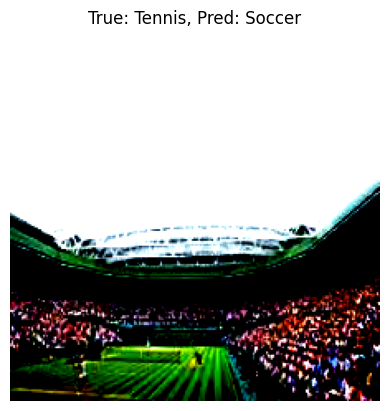

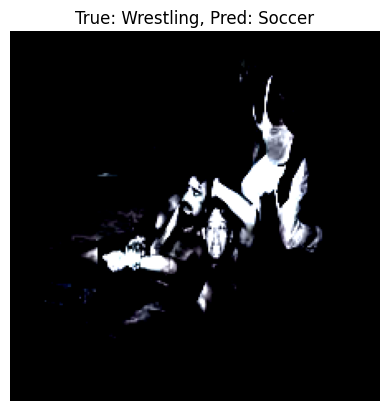

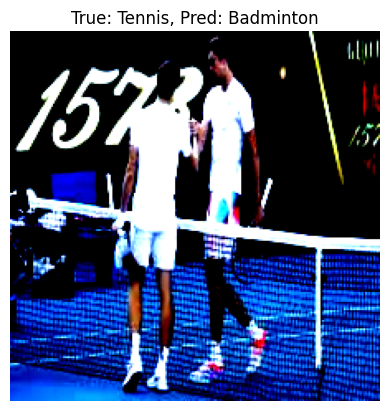

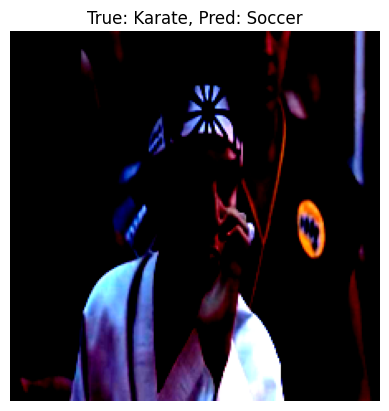

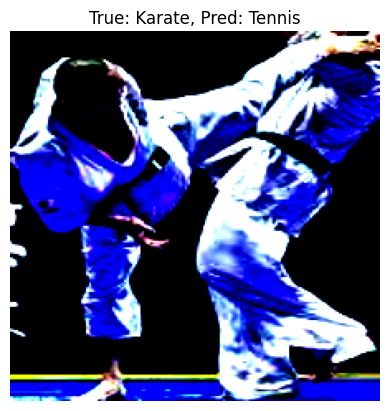

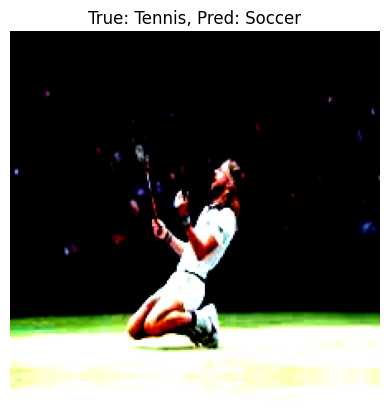

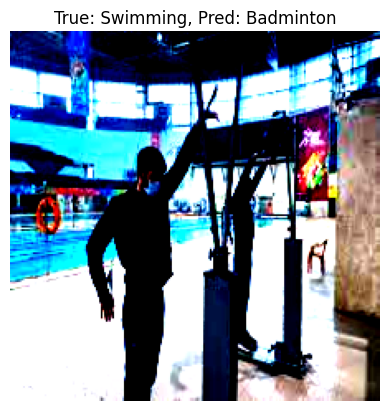

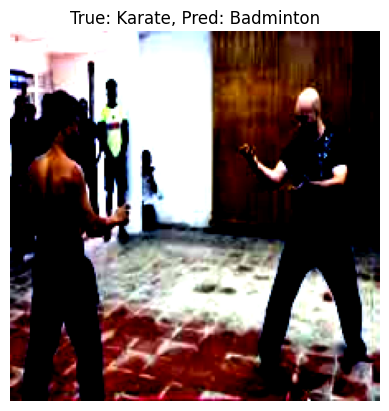

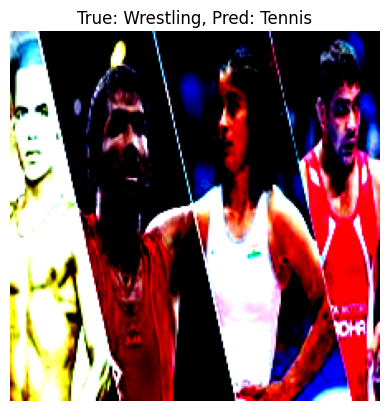

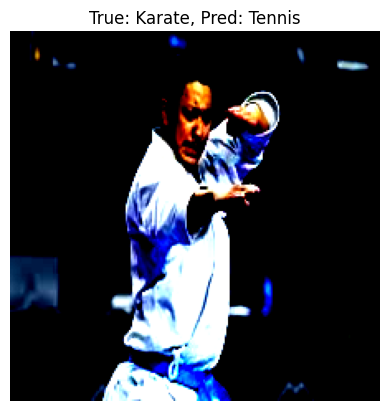

In [90]:
show_misclassified(model, val_loader, class_names, device, max_images=2057)


run tenserboard


In [ ]:
!zip -r runs_logs.zip runs/


In [89]:
%load_ext tensorboard
%tensorboard --logdir runs


<IPython.core.display.Javascript object>